# Conditional Flow-Matching
We learn the galaxy phase space densities from gaia data

In [1]:
from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.configs.mnist_configs import MNIST_UNet_CondFlowMatch as Config

config = Config(NAME = 'noise_to_mnist',
                DATA_SOURCE = 'noise',
                DATA_TARGET = 'mnist',
                DATA_SPLIT_FRACS = [0.8, 0.2, 0.0],
                BATCH_SIZE = 1024,
                EPOCHS = 1,
                LR = 1e-4,
                DIM_HIDDEN = 32, 
                SIGMA = 0.0,
                SOLVER ='midpoint',
                NUM_SAMPLING_STEPS = 1000)

#...set working directory for results:

config.set_workdir(path='../../results', save_config=True)



#=========================================================================================
INFO: created directory: ../../results/noise_to_mnist.CondFlowMatch.Unet.2024.02.10_16h36
#=========================================================================================
+---------------------+-----------------+
| Parameters          | Values          |
+---------------------+-----------------+
| NAME                | noise_to_mnist  |
| DATA_SOURCE         | noise           |
| DATA_TARGET         | mnist           |
| DIM_INPUT           | 784             |
| INPUT_SHAPE         | (1, 28, 28)     |
| DEVICE              | cpu             |
| OPTIMIZER           | Adam            |
| LR                  | 0.0001          |
| WEIGHT_DECAY        | 0.0             |
| OPTIMIZER_BETAS     | [0.9, 0.999]    |
| OPTIMIZER_EPS       | 1e-08           |
| OPTIMIZER_AMSGRAD   | False           |
| GRADIENT_CLIP       |                 |
| SCHEDULER           |                 |
| SCHEDULER_T_

In [2]:
from DynGenModels.datamodules.mnist.datasets import MNISTDataset 
mnist = MNISTDataset(config)

In [3]:
from DynGenModels.dynamics.cnf.condflowmatch import CondFlowMatching
from DynGenModels.datamodules.mnist.dataloader import MNISTDataloader
from DynGenModels.models.unet import Unet

cfm = DynGenModelTrainer(dynamics = CondFlowMatching(config), 
                         model = Unet(config),
                         dataloader = MNISTDataloader(mnist, config), 
                         configs = config)

AttributeError: 'Configs' object has no attribute 'data_split_fracs'

### generate data from trained model:

In [6]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
from DynGenModels.datamodules.gaia.dataprocess import PostProcessGaiaData 

pipeline = FlowMatchPipeline(trained_model=cfm, 
                             source_input=torch.randn(100000, 6),
                             configs=config, 
                             postprocessor=PostProcessGaiaData)

INFO: neural ODE solver with midpoint method and steps=300
INFO: post-processing sampled data with ['inverse_standardize', 'inverse_radial_blowup', 'inverse_unit_ball_transform']


###  Performance plots

/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22116/1037512289.py:24: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(8)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22116/1037512289.py:33: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax_ratio.set_ylim(0.5, 1.5, 0) # Adjust this as needed
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22116/1037512289.py:37: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(7)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22116/1037512289.py:39: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be remo

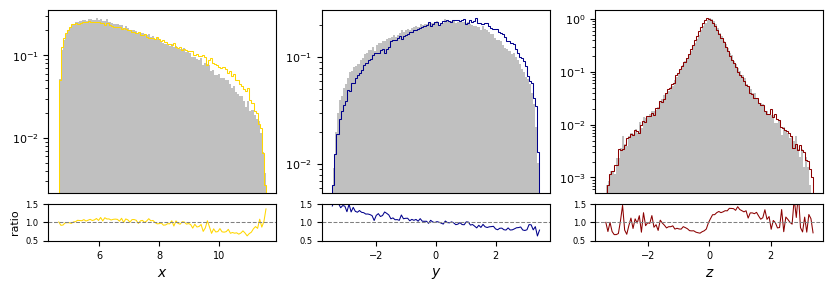

/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22116/1037512289.py:24: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(8)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22116/1037512289.py:33: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax_ratio.set_ylim(0.5, 1.5, 0) # Adjust this as needed
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22116/1037512289.py:37: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(7)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22116/1037512289.py:39: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be remo

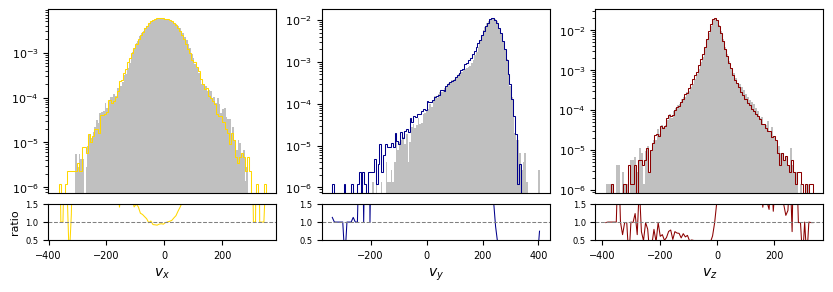

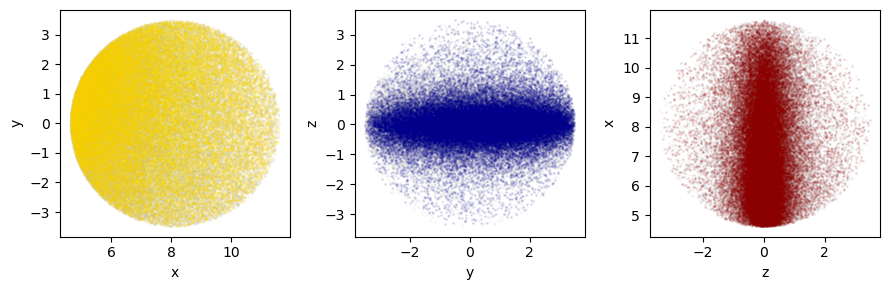

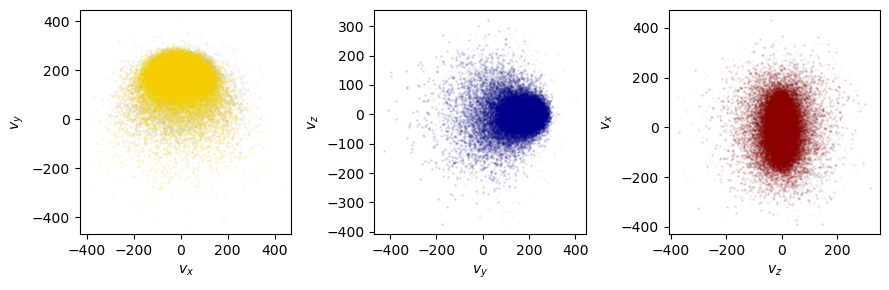

In [7]:
from utils import results_plots

results_plots(gaia.target[..., :3],  
              generated=pipeline.target[..., :3],
              save_dir=configs.workdir,
              features=[r'$x$', r'$y$', r'$z$'], 
              num_particles=100000,
              name_file='gaia_postions')

results_plots(gaia.target[..., 3:], 
              generated=pipeline.target[..., 3:],
              save_dir=configs.workdir,
              features=[r'$v_x$', r'$v_y$', r'$v_z$'], 
              num_particles=100000,
              name_file='gaia_velociites')

coord = ['x', 'y', 'z']
color=['gold', 'darkblue', 'darkred']
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].scatter(gaia.target[:50000, i], gaia.target[:50000, j], s=1, alpha=0.1, c='silver')
    ax[i].scatter(pipeline.target[:50000, i], pipeline.target[:50000, j], s=1, alpha=0.1, c=color[i])
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()

coord = [r'$v_x$', r'$v_y$', r'$v_z$']
color=['gold', 'darkblue', 'darkred']
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].scatter(gaia.target[:50000, i+3], gaia.target[:50000, j+3], s=1, alpha=0.1, c='silver')
    ax[i].scatter(pipeline.target[:50000, i+3], pipeline.target[:50000, j+3], s=1, alpha=0.1, c=color[i])
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()


# Normalizing Flow
We learn the galaxy phase space densities from gaia data with a MAF

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt 

from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.configs.gaia_configs import Gaia_Couplings_RQS_NormFlow as Configs

configs = Configs(DATA = 'h277',
                 features = ['x', 'y', 'z', 'vx', 'vy', 'vz'],
                 data_split_fracs = [0.8, 0.2, 0.0],
                 preprocess=['unit_ball_transform', 'radial_blowup', 'standardize'],
                 batch_size = 2048,
                 EPOCHS = 20,
                 lr = 1e-4,
                 num_blocks = 2,
                 mask = 'mid-split',
                 num_bins = 10,
                 tail_bound = 10, 
                 dim_hidden = 32,
                 num_transforms = 4,
                 num_workers = 8,
                 pin_memory = True,
                )
#...set working directory for results:

configs.set_workdir(path='../../results', save_config=True)

#===================================================================================
INFO: created directory: ../../results/h277.NormFlow.Couplings_RQS.2023.10.11_20h37
#===================================================================================
+---------------------+--------------------------------------------------------------------------------------------------------+
| Parameters          | Values                                                                                                 |
+---------------------+--------------------------------------------------------------------------------------------------------+
| DATA                | h277                                                                                                   |
| dataset             | ['../../data/gaia/data.angle_340.smeared_00.npy', '../../data/gaia/data.angle_340.smeared_00.cov.npy'] |
| features            | ['x', 'y', 'z', 'vx', 'vy', 'vz']                                            

In [5]:
from DynGenModels.datamodules.gaia.datasets import GaiaDataset 
from DynGenModels.datamodules.gaia.dataloader import GaiaDataLoader 
from DynGenModels.models.nflow_nets import CouplingsPiecewiseRQS
from DynGenModels.dynamics.nf.normflows import NormalizingFlow

gaia = GaiaDataset(configs)

nf = DynGenModelTrainer(dynamics=NormalizingFlow(configs),
                        model=CouplingsPiecewiseRQS(configs), 
                        dataloader=GaiaDataLoader(gaia, configs), 
                        configs=configs)
nf.train()

INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 128667, validation size: 32166, testing sizes: 1
INFO: number of training parameters: 28892


epochs:   0%|          | 0/20 [00:00<?, ?it/s]

In [6]:
from DynGenModels.pipelines.SamplingPipeline import NormFlowPipeline
from DynGenModels.datamodules.gaia.dataprocess import PostProcessGaiaData 

pipeline = NormFlowPipeline(trained_model=coupl, 
                            num_gen_samples=100000,
                            configs=configs, 
                            postprocessor=PostProcessGaiaData)

INFO: post-processing sampled data with ['inverse_standardize', 'inverse_radial_blowup', 'inverse_unit_ball_transform']


/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22614/1037512289.py:24: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(8)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22614/1037512289.py:33: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax_ratio.set_ylim(0.5, 1.5, 0) # Adjust this as needed
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22614/1037512289.py:37: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(7)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22614/1037512289.py:39: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be remo

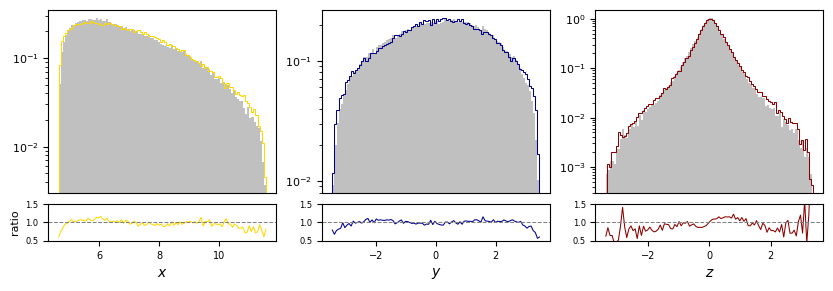

/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22614/1037512289.py:24: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(8)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22614/1037512289.py:33: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax_ratio.set_ylim(0.5, 1.5, 0) # Adjust this as needed
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22614/1037512289.py:37: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(7)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22614/1037512289.py:39: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be remo

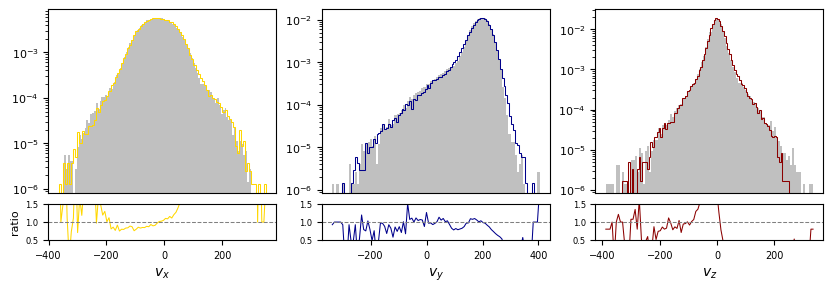

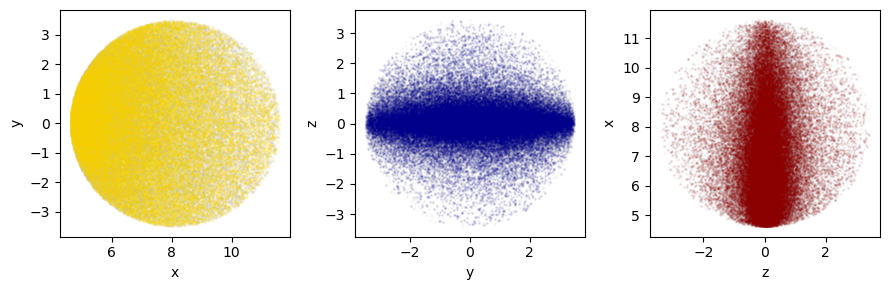

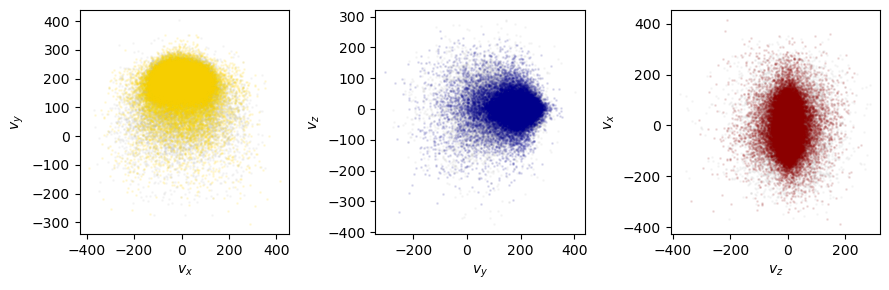

In [7]:
results_plots(gaia.target[..., :3],  
              generated=pipeline.target[..., :3],
              save_dir=configs.workdir,
              features=[r'$x$', r'$y$', r'$z$'], 
              num_particles=100000,
              name_file='gaia_postions')

results_plots(gaia.target[..., 3:], 
              generated=pipeline.target[..., 3:],
              save_dir=configs.workdir,
              features=[r'$v_x$', r'$v_y$', r'$v_z$'], 
              num_particles=100000,
              name_file='gaia_velociites')

coord = ['x', 'y', 'z']
color=['gold', 'darkblue', 'darkred']
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].scatter(gaia.target[:50000, i], gaia.target[:50000, j], s=1, alpha=0.1, c='silver')
    ax[i].scatter(pipeline.target[:50000, i], pipeline.target[:50000, j], s=1, alpha=0.1, c=color[i])
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()

coord = [r'$v_x$', r'$v_y$', r'$v_z$']
color=['gold', 'darkblue', 'darkred']
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].scatter(gaia.target[:50000, i+3], gaia.target[:50000, j+3], s=1, alpha=0.1, c='silver')
    ax[i].scatter(pipeline.target[:50000, i+3], pipeline.target[:50000, j+3], s=1, alpha=0.1, c=color[i])
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()
